In [2]:
!pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.10.post3
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.3
aiosignal                                1.4.0
aiosqlite                                0.22.1
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.18.2
altair                                   5.5.0
annotated-doc                            0.0.4
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                         

In [3]:
!python --version

Python 3.12.12


In [4]:
!pip install diffusers

In [5]:
from huggingface_hub import notebook_login

notebook_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

查询当前是否使用GPU

In [7]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Using device: cuda


添加显示图片函数

In [8]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image

def show_images(x):
  x = x * 0.5 + 0.5
  grid = torchvision.utils.make_grid(x)
  grid_im = grid.detach().cpu().permute(1,2,0).clip(0,1) * 255
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
  return grid_im

def make_grid(images, size=64):
  output_im = Image.new("RGB", (size * len(images), size))
  for i,im in enumerate(images):
    output_im.paste(im.resize((size, size)), (i * size, 0))
  return output_im

# 1. 管线加载预训练模型生成图像

1. 加载管线（蛋头先生）

In [9]:
from diffusers import StableDiffusionPipeline

model_id = "sd-dreambooth-library/mr-potato-head"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

2. 生成图像（蛋头先生.毕加索版）

In [ ]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

In [ ]:
prompt = "an abstract oil painting of mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

3. 加载管线并生成蝴蝶图像

In [ ]:
from diffusers import DDPMPipeline

butterfly_pipeline = DDPMPipeline.from_pretrained("johnowhitaker/ddpm-butterflies-32px").to(device)

images = butterfly_pipeline(batch_size=8).images

make_grid(images)

# 2. 自己训练生成蝴蝶图像的模型

#### 2.1 下载蝴蝶图像集，并随机显示前8张

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

X shape: torch.Size([8, 3, 32, 32])


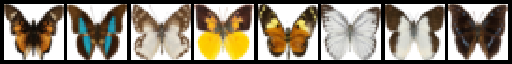

In [10]:
import torch
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
# 从本地文件夹中加载图像
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# 使用32x32像素的正方形图像进行训练，也可以尝试使用更大尺寸的
image_size = 32

# GPU内存不足时，也可以减小batch_size
batch_size = 64

# 定义数据增强过程
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # 调整大小
        transforms.RandomHorizontalFlip(),  # 随机反转
        transforms.ToTensor(),  # 将张量映射到(0,1)区间
        transforms.Normalize([0.5], [0.5]),  # 映射到(-1,1)区间
    ]
)

def transform(examples):
  images = [preprocess(image.convert("RGB")) for image in examples["image"]]
  return {"images": images}

dataset.set_transform(transform)

# 创建数据加载器，批量提供经过变换的图像
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 取出一批图像数据并进行可视化
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

# 输出结果： X shape: torch.Size([8, 3, 32, 32])

#### 2.2 添加调度器(加噪)

Noisy X shape torch.Size([8, 3, 32, 32])


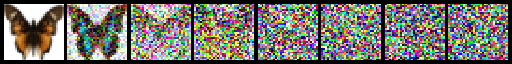

In [11]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# 通过修改下面的参数来对调度器的超参数beta进行控制

# beta_start：推理阶段开始时 beta 的值
# beta_end：控制 beta 的最终值
# 示例1： noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

# beta_schedule：通过函数映射来为模型推理的每一步生成一个 beta 值（下面示例为cosine函数的调度方式）
# 示例2： noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')


timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

#### 2.3 定义扩散模型

In [12]:
from diffusers import UNet2DModel

# 创建模型
model = UNet2DModel(
    sample_size=image_size,     # 目标图像的分辨率
    in_channels=3,          # 输入通道数，RGB图像通道数为3，灰度图像通道数为1
    out_channels=3,         # 输出图像的通道数
    layers_per_block=2,       # 设置在一个UNet块中使用多少个ResNet层
    block_out_channels=(32, 128, 128, 256), # 每个UNet块的输出通道数，与BasicNet基本相同
    down_block_types=(
        "DownBlock2D",     # 标准的ResNet下采样模块
        "DownBlock2D",
        "AttnDownBlock2D",   # 带有空间自注意力的ResNet下采样模块
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",    # 带有空间自注意力的ResNet上采样模块
        "AttnUpBlock2D",
        "UpBlock2D",      # 标准的ResNet上采样模块
        "UpBlock2D",
    ),
)

model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [14]:
with torch.no_grad():    # 随机输入一批数据和随机迭代周期数，查看输出尺寸与输入尺寸是否相同
  model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape    # 输出内容：torch.Size([8, 3, 32, 32])

torch.Size([8, 3, 32, 32])

#### 2.4 创建扩散模型训练循环

Epoch:5, loss:0.0841307477094233
Epoch:5, loss:0.08211044501513243
Epoch:5, loss:0.08026258088648319
Epoch:5, loss:0.0804773960262537
Epoch:5, loss:0.08136681839823723
Epoch:5, loss:0.08015877893194556
Epoch:5, loss:0.08183560520410538
Epoch:5, loss:0.08105332776904106
Epoch:5, loss:0.08070209296420217
Epoch:5, loss:0.08050241973251104
Epoch:5, loss:0.0800031553953886
Epoch:5, loss:0.07865721825510263
Epoch:5, loss:0.08008465310558677
Epoch:5, loss:0.08092747256159782
Epoch:5, loss:0.08123326767235994
Epoch:5, loss:0.08240024140104651
Epoch:10, loss:0.07228451687842607
Epoch:10, loss:0.07338171498849988
Epoch:10, loss:0.07192378910258412
Epoch:10, loss:0.07292275503277779
Epoch:10, loss:0.07405402418226004
Epoch:10, loss:0.07590127573348582
Epoch:10, loss:0.07740080705843866
Epoch:10, loss:0.07884763949550688
Epoch:10, loss:0.0808333430904895
Epoch:10, loss:0.07963915285654366
Epoch:10, loss:0.0798031019512564
Epoch:10, loss:0.07907389313913882
Epoch:10, loss:0.07828107546083629
Epoch:

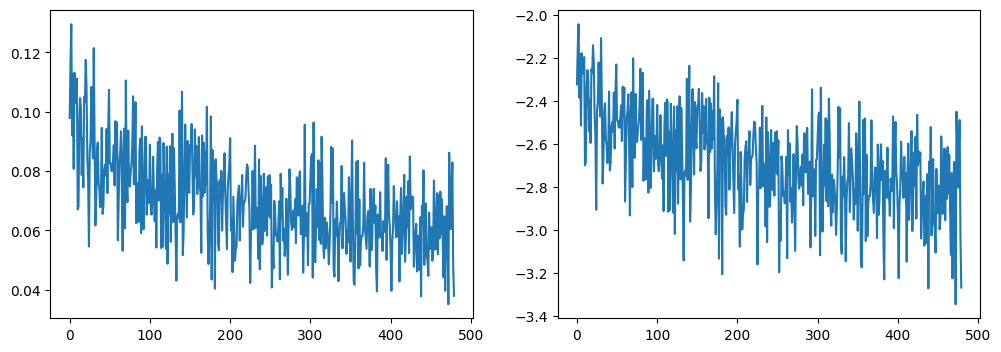

In [17]:
# 设定噪声调度器
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,beta_schedule="squaredcos_cap_v2"
)

# 训练循环
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
  for step, batch in enumerate(train_dataloader):
    clean_images = batch["images"].to(device)
    # 为图片添加噪声
    noise = torch.randn(clean_images.shape).to(clean_images.device)
    bs = clean_images.shape[0]

    # 为每张图片随机采样一个时间步
    timesteps = torch.randint(
        0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

    # 根据每个时间步的噪声幅度，向每个清晰的图片中加噪
    noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

    # 获得模型的预测结果
    noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

    # 计算损失
    loss = F.mse_loss(noise_pred, noise)
    loss.backward(loss)
    losses.append(loss.item())

    # 迭代模型参数
    optimizer.step()
    optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
      loss_last_epoch = sum(losses[-len(train_dataloader):])/len(train_dataloader)
      print(f"Epoch:{epoch+1}, loss:{loss_last_epoch}")

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()